In [1]:
import os
import torch
import GPUtil
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from model.model import PODNonlinearModel
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

In [2]:
import matplotlib.pyplot as plt
from vecopsciml.operators.zero_order import Mx, My
import time

In [3]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/non_linear/non_linear_10000.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear/POD_model')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/POD_model


In [4]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear/non_linear_10000.pkl


In [5]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda


In [7]:
# Train data splitting in train/test
X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

# Data processing and adequacy with our TensOps library
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

# Loading and processing validation data
X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

In [8]:
A = y_train.values.detach().to('cpu').squeeze().view(y_train.values.detach().shape[0], -1)

In [9]:
print(A.shape)

torch.Size([5600, 100])


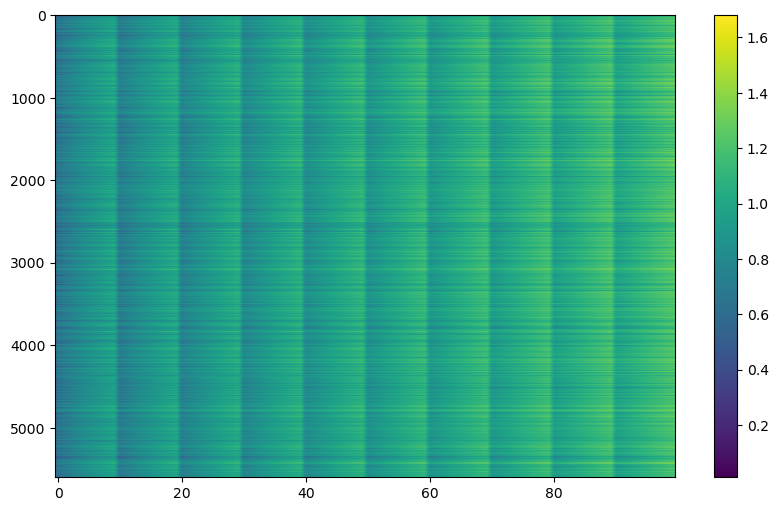

torch.Size([5600, 100])


In [10]:
plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
plt.imshow(A, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

print(A.shape)

In [11]:
U, S, Vt = torch.linalg.svd(A, full_matrices=False)

print(f"{list(U.shape)} x {list(S.shape)} x {list(Vt.shape)}")

[5600, 100] x [100] x [100, 100]


In [12]:
num_modes = 30

Ur = U[:, :num_modes]
Sr = S[:num_modes]
Vtr = Vt[:num_modes, :]

print(f"{list(Ur.shape)} x {list(Sr.shape)} x {list(Vtr.shape)}")

[5600, 30] x [30] x [30, 100]


In [13]:
Ar = torch.mm(torch.mm(Ur, torch.diag(Sr)), Vtr)

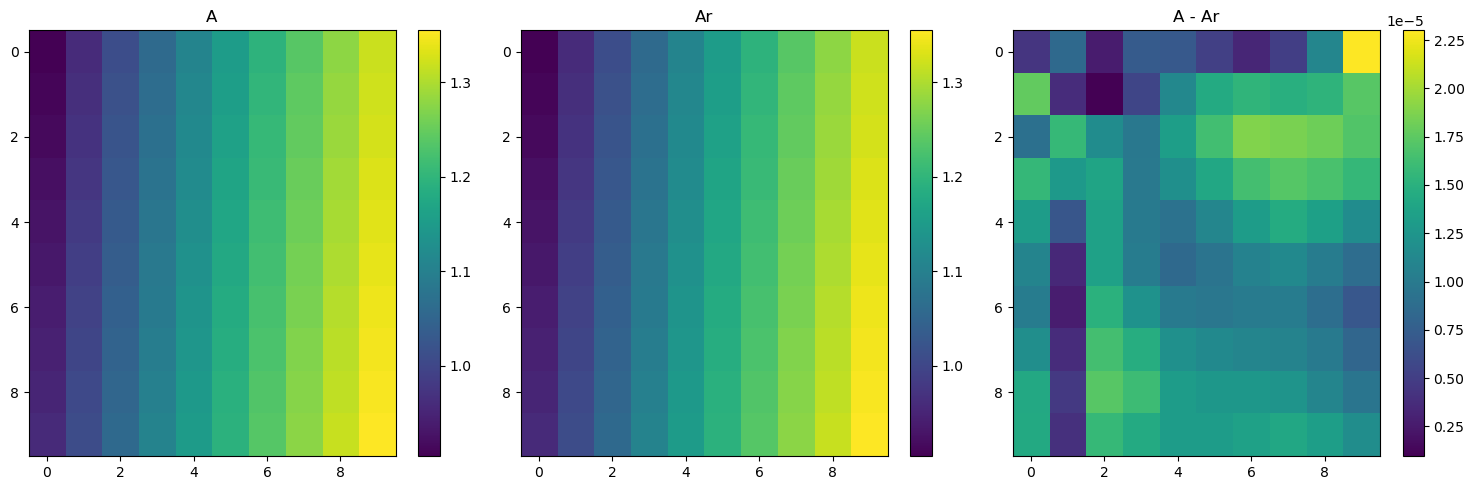

In [14]:
# Crear una figura con 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar A en el primer gráfico
axes[0].imshow(A[0].view(10, 10), aspect='auto', cmap='viridis')
axes[0].set_title('A')
plt.colorbar(axes[0].imshow(A[0].view(10, 10), aspect='auto', cmap='viridis'), ax=axes[0])

# Mostrar Ar en el segundo gráfico
axes[1].imshow(Ar[0].view(10, 10), aspect='auto', cmap='viridis')
axes[1].set_title('Ar')
plt.colorbar(axes[1].imshow(Ar[0].view(10, 10), aspect='auto', cmap='viridis'), ax=axes[1])

# Mostrar la diferencia A - Ar en el tercer gráfico
axes[2].imshow(abs((A - Ar))[0].view(10, 10), aspect='auto', cmap='viridis')
axes[2].set_title('A - Ar')
plt.colorbar(axes[2].imshow(abs((A - Ar))[0].view(10, 10), aspect='auto', cmap='viridis'), ax=axes[2])

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


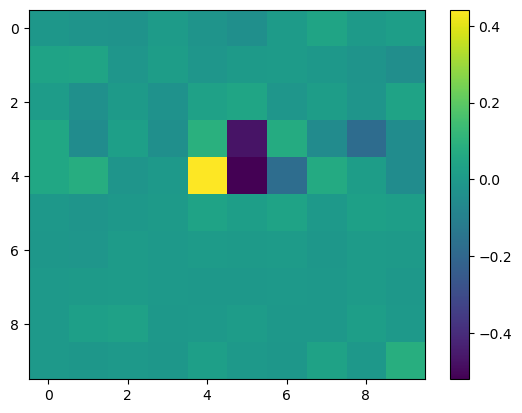

In [15]:
# plt.figure(figsize=(7, 6))  # Ajustar el tamaño del gráfico
plt.imshow(U[1].view(10, 10), aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

In [16]:
U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)

error = []
for mode_i in range(len(S_train)):
    error.append((sum(S_train[:mode_i])/sum(S_train)).numpy())
    if mode_i < 20:
        print(mode_i, '-->', error[mode_i])

0 --> 0.0
1 --> 0.90155274
2 --> 0.9484499
3 --> 0.99119854
4 --> 0.9941892
5 --> 0.99641645
6 --> 0.99841464
7 --> 0.99887806
8 --> 0.9992371
9 --> 0.99948627
10 --> 0.99969864
11 --> 0.99978
12 --> 0.9998438
13 --> 0.99989223
14 --> 0.9999195
15 --> 0.9999432
16 --> 0.99995655
17 --> 0.99996847
18 --> 0.9999759
19 --> 0.9999818


In [22]:
num_modes = 13

start_time = time.time()

U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)

U_reduced_train = U_train[:, :num_modes]
S_reduced_train = S_train[:num_modes]
Vt_reduced_train = Vt_train[:num_modes, :]

POD_base = Vt_reduced_train.to(DEVICE)
# y_train = Vt_reduced_train.T

end_time = time.time()

print(f"Tiempo de ejecución: {end_time - start_time:.6f} segundos")

Tiempo de ejecución: 0.047320 segundos


In [23]:
print(U_train.shape)

torch.Size([5600, 100])


In [24]:
# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, num_modes]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10, 10]
explanatory_output = Mx(My(f_train)).values[0].shape

# Other parameters
n_filters_explanatory = 5

In [25]:
POD_base.shape

torch.Size([13, 100])

In [ ]:
u, K = model(X_train)

print(K.shape)

torch.Size([5600, 1, 9, 9])


In [ ]:
import torch
import torch.nn as nn

from vecopsciml.utils import TensOps
from vecopsciml.operators.zero_order import Mx, My

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_layer_1_size, hidden_layer_2_size, latent_space_size):
        super(Encoder, self).__init__()

        # Parameters
        self.in_size = torch.tensor(input_size)
        self.h1_size = hidden_layer_1_size
        self.h2_size = hidden_layer_2_size
        self.ls_size = latent_space_size

        # Architecture
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=-1)
        self.hidden1_layer = nn.Linear(torch.prod(self.in_size), self.h1_size)
        self.hidden2_layer = nn.Linear(self.h1_size, self.h2_size)
        self.latent_space_layer = nn.Linear(self.h2_size, self.ls_size)
    
    def forward(self, X):
        
        X = self.flatten_layer(X)
        X = torch.sigmoid(self.hidden1_layer(X))
        X = torch.sigmoid(self.hidden2_layer(X))
        latent_space_output = (self.latent_space_layer(X))

        return latent_space_output
    
class Explanatory(nn.Module):

    def __init__(self, input_size, n_filters, hidden_layer_size, output_size):
        super(Explanatory, self).__init__()

        # Parameters
        self.in_size = torch.tensor(input_size)
        self.n_filters = n_filters * 1
        self.h_layer = hidden_layer_size
        self.out_size = torch.tensor(output_size)

        # Architecture
        self.conv_expand_layer = nn.Conv2d(in_channels=1, out_channels=self.n_filters, kernel_size=1)
        self.hidden_layer_1 = nn.Linear(self.n_filters, self.h_layer)
        self.hidden_layer_2 = nn.Linear(self.h_layer, self.n_filters)
        self.conv_converge_layer = nn.Conv2d(in_channels=self.n_filters, out_channels=1, kernel_size=1)
        
    def forward(self, X):

        batch_size, _, height, width = X.shape
        
        X = self.conv_expand_layer(X)
        X = X.permute(0, 2, 3, 1)  # (batch, height, width, channels)
        X = X.reshape(-1, X.size(-1))  # (batch * height * width, channels)

        X = torch.sigmoid(self.hidden_layer_1(X))
        X = torch.sigmoid(self.hidden_layer_2(X))
        
        X = X.reshape(batch_size, height, width, -1)
        X = X.permute(0, 3, 1, 2)  # (batch, channels, height, width)
        explanatory_output = self.conv_converge_layer(X)

        return explanatory_output
    
class PODNonlinearModel(nn.Module):
    
    def __init__(self, input_size, predictive_layers, POD_base, output_predictive_size, explanatory_input_size, explanatory_layers, output_explanatory_size, n_filters):
        
        super(PODNonlinearModel, self).__init__()

        # Parameters
        self.in_size = input_size
        self.pred_size = predictive_layers
        self.out_pred_size = output_predictive_size
        
        self.in_exp_size = explanatory_input_size
        self.exp_size = explanatory_layers
        self.out_exp_size = output_explanatory_size

        self.n_filters = n_filters

        # Architecture
        self.encoder = Encoder(self.in_size, self.pred_size[0], self.pred_size[1], self.pred_size[2])
        self.base = POD_base
        self.explanatory = Explanatory(self.in_exp_size, self.n_filters, self.exp_size[0], self.out_exp_size)

    def forward(self, X):

        # Predictive network
        X = self.encoder(X)

        # Reconstruction with POD and manipulation of prediction output
        u = torch.mm(X, self.base).reshape(X.size(0), *self.out_pred_size)
        um = Mx(My(TensOps(u, space_dimension=2, contravariance=0, covariance=0))).values

        # Explanatory network
        K = self.explanatory(um)
        
        return u, K
    
model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
# Load model and the optimizer
model = PODNonlinearModel(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# # Parametros de entrenamiento
# start_epoch = 0
# n_epochs = 10000

# batch_size = 64
# n_checkpoints = 10

# train_loop(model, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
#            D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
#            model_results_path=MODEL_RESULTS_PATH, device=DEVICE)

In [ ]:
# # Parametros de entrenamiento
# start_epoch = 9000
# n_epochs = 100000

# batch_size = 64
# n_checkpoints = 100

# second_lr = 1e-4

# train_loop(model, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
#            D,  n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
#            model_results_path=MODEL_RESULTS_PATH, device=DEVICE, new_lr=second_lr)